# Training

This notebook deals with training the neural network to classify images as photoshopped or not and is desgined to be run on google colab to make use of their free GPU

## Imports

In [ ]:
# Modules required
import sys
import os
import importlib
import joblib
import itertools
from sklearn.model_selection import ParameterGrid
import shutil

## Colab setup

Training neural nets on my laptop is very slow so I used Google Colab to speed things up a bit. This function gets run if I am using Colab which does some setup like downloading the dataset from github and linking my google drive so that model logs can get saved.

In [ ]:
def colab_setup():
    # Install split folders
    !pip install split_folders
    import split_folders

    # Specify tensorflow version 2.0 and import, checking that gpu is used
    %tensorflow_version 2.x|
    import tensorflow as tf

    # Check that the GPU is being used
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

    # Add the project directory to path, allows access to items saved in google drive   
    if project_dir not in sys.path:
        sys.path.append(project_dir)

    # If there is no data in this directory and on colab then copy the data
    if not os.path.exists('./data'):

        # Download raw data from github onto colab instance and move it into the raw data directory, utilises sparse checkout
        !git init
        !git config core.sparsecheckout true
        !echo data >> .git/info/sparse-checkout
        !git remote add origin -f https://github.com/Rees451/faces-fake-vs-real
        !git pull origin master

    # Setup the problem as a ovr problem by running the ovr_file_sorter.py script
    # This script seperates photoshopped images for each feature, i.e. eyes, mouth
    # and nose
    # src = f'./data/raw'
    # dest = f'./data/processed'
    # %run "{project_dir+'/src/ovr_file_sorter.py'}" $src $dest

## General Setup

In [3]:
# Raw data location
relative_raw_data_loc = '/data/raw/real_and_fake_face'

# Add local drive to path if running on colab
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
    project_dir = '..'
    local_project_dir = project_dir
else:
    device_loc = 'colab'
    local_project_dir = '.'

    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    project_dir = 'drive/My Drive/GA/Capstone/faces-fake-vs-real'

    # Run setup function
    colab_setup()

# Define the raw data location
raw_fake_vs_real_dir = local_project_dir + relative_raw_data_loc

# Define the model save/load location

# Append
sys.path.append(project_dir + '/src')

# Import tensorflow, needs to be done after specifiying %tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorboard.plugins.hparams import api as hp

# Loading is one of my modules so need to import after linking my google drive
import loading as ld

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x|`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Found GPU at: /device:GPU:0
Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6692 (delta 1), reused 4 (delta 0), pack-reused 6686
Receiving objects: 100

## Train test split

In [ ]:
# problem specifies what we are trying to classify, for example all indicates 
# that we are trying to classify the whether a face has been photoshopped at all
# left_eye would indicate whether we are trying to classify that the left eye 
# has been photoshopped or not
def train_val_test_split_folders(problem, ratio    = (.8, .1, .1), force=False):
    '''
    Write docstring
    '''

    if problem == 'all':
        origin_path = f'{local_project_dir}/{relative_raw_data_loc}'
    else:
        origin_path = f'{local_project_dir}/data/processed/real_and_fake_face_ovr_links/{problem}'

    problem_path = f'{local_project_dir}/data/processed/sf/{problem}'

    if force:
        !rm -rf $problem_path

    # Copy if doens't allready exist
    if not os.path.exists(problem_path):
        split_folders.ratio(origin_path, problem_path, ratio= (.8, .1, .1))

    # Store the resulting train, test, val paths as strings
    train_dir = problem_path+'/train'
    test_dir = problem_path+'/test'
    val_dir = problem_path+'/val'
    return train_dir, val_dir, test_dir

In [5]:
# Run model training script
train_val_test_split_folders('all', force=False)

('./data/processed/sf/all/train',
 './data/processed/sf/all/val',
 './data/processed/sf/all/test')

## Train a single model

In [ ]:
data_dir= project_dir+'/data/processed/sf/all'
model_dir = project_dir+'/models'
# %run "{project_dir+'/src/train.py'}" "$model_id" "$data_dir" "$model_save_dir"

I initially utilised keras's `ImageDataGenerator` to load the data but when training I found it was much faster to use the `tf.data` api. As such I wrote a [class](../src/loading.py) to load the images and their corresponding labels in this way. I used some iamge augmentation in order to improve generalisability (and artifically increase the size of the training set).

In [ ]:
def train_model(model, model_id='', epochs=15,
                patience=5):

    # Get the input_shape the model requires
    input_shape = model.input.get_shape().as_list()[-3:-1]
    
    # Load the data using DsLoader class
    data = ld.DsLoader(data_dir, image_size=input_shape)
    train = data.get_ds(split='train', augment=True, batch_size=32)
    val = data.get_ds(split='val', augment=True, batch_size=32)

    # Early stopping function
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                          verbose=1,
                                          patience=patience)

    # Setup a model checkpoint to save our best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'{model_dir}/{model_id}.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
    )

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #  Fit the tensorflow model
    model_fit = model.fit(train,
                          epochs=epochs,
                          validation_data=val,
                          callbacks=[checkpoint, es])

    # Save the model fit history
    joblib.dump(model_fit.history, f'{model_dir}/{model_id}_history.gz')

    return model

In [ ]:
cnn1_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='selu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='selu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='selu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(units=128, activation='selu'),
    layers.Dense(units=2, activation='softmax')
])

history = train_model(cnn1_model, model_id='c3_test', epochs=8, patience=4)

Epoch 1/8
     51/Unknown - 29s 575ms/step - loss: 1.1335 - accuracy: 0.5061
Epoch 00001: val_accuracy improved from -inf to 0.51471, saving model to ../models/c3_test.h5
51/51 [==============================] - 33s 642ms/step - loss: 1.1335 - accuracy: 0.5061 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/8
50/51 [============================>.] - ETA: 0s - loss: 0.8495 - accuracy: 0.5506
Epoch 00002: val_accuracy improved from 0.51471 to 0.53431, saving model to ../models/c3_test.h5
51/51 [==============================] - 14s 282ms/step - loss: 0.8494 - accuracy: 0.5509 - val_loss: 0.7596 - val_accuracy: 0.5343
Epoch 3/8
50/51 [============================>.] - ETA: 0s - loss: 0.7936 - accuracy: 0.5744
Epoch 00003: val_accuracy did not improve from 0.53431
51/51 [==============================] - 14s 281ms/step - loss: 0.7935 - accuracy: 0.5772 - val_loss: 0.7553 - val_accuracy: 0.5294
Epoch 4/8
50/51 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0

## Data test

In [ ]:
data = ld.DsLoader('../data/processed/sf/subset', image_size=(64,64))
train = data.get_ds(split='train', batch_size=2, augment=True, n_repeats=1)
val = data.get_ds(split='val', batch_size=2, augment=True, n_repeats=3)

In [ ]:
for i in data.list_ds:
    print(i)

tf.Tensor(b'../data/processed/sf/subset/val/real/real_00039.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/fake/easy_63_1110.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/fake/easy_14_1111.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/fake/easy_13_1010.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/real/real_00041.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/real/real_00003.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/fake/easy_60_1111.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/processed/sf/subset/val/real/real_00031.jpg', shape=(), dtype=string)


(2, 64, 64, 3)
tf.Tensor([1 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 0], shape=(2,), dtype=int32)


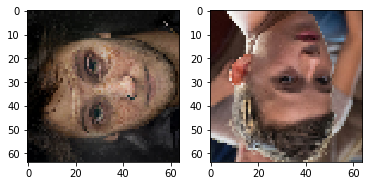

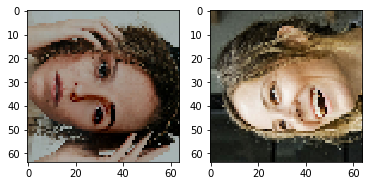

In [ ]:
for img, label in train.take(2):
    print(img.shape)
    print(label)
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(img[0])
    ax[1].imshow(img[1])

(2, 64, 64, 3)
tf.Tensor([0 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 1], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([1 0], shape=(2,), dtype=int32)
(2, 64, 64, 3)
tf.Tensor([0 1], shape=(2,), dtype=int32)


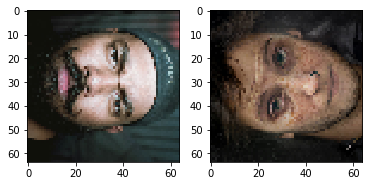

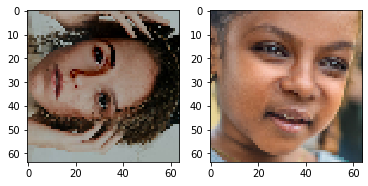

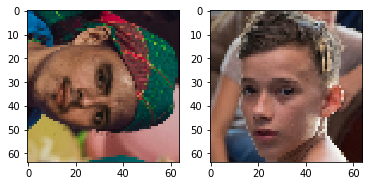

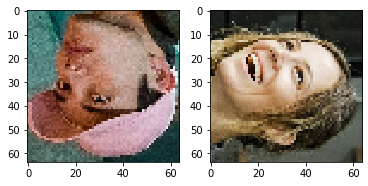

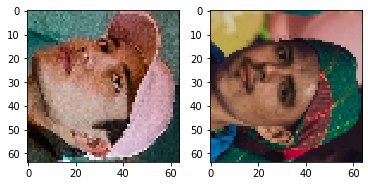

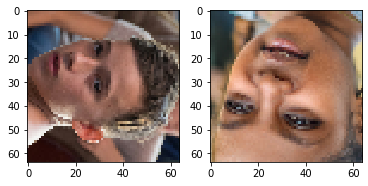

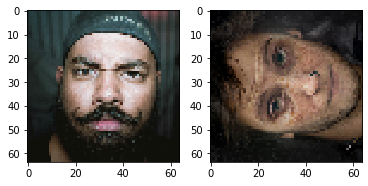

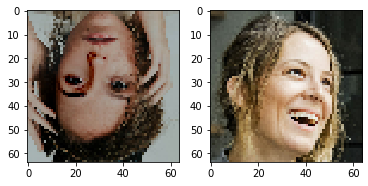

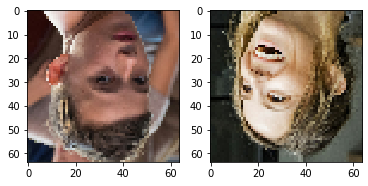

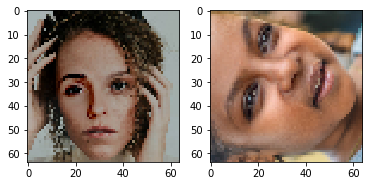

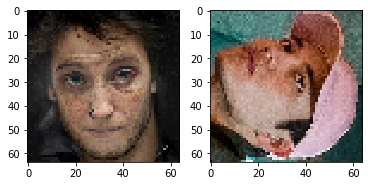

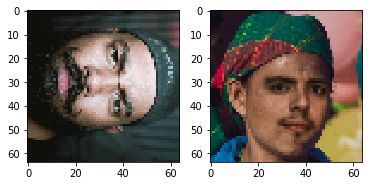

In [ ]:
for img, label in val.take(15):
    print(img.shape)
    print(label)
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(img[0])
    ax[1].imshow(img[1])

## Hyperparameter tuning

In [ ]:
# Function to construct the model, with various hyperparamters
def build_model(img_width=64,
                num_conv_blocks=3,
                num_filters=32,
                filter_size=3,
                n_output_units=2,
                dilation_rate=1):
    
    # Consituent model blocks
    def conv_block(x, num_filters, filter_size, dilation_rate, block):
        x = layers.Conv2D(num_filters,
                          filter_size,
                          activation='relu',
                          padding='same',
                          dilation_rate=dilation_rate,
                          name=f'conv_{block}')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2), name=f'pool_{block}')(x)
        x = layers.BatchNormalization(name=f'norm_{block}')(x)
        return x


    def output_block(x, n_output_units):
        x = layers.Flatten(name='output_flatten')(x)
        x = layers.Dense(units=n_output_units, activation='softmax',
                         name='output')(x)
        return x

    # Covert hparams to tuples where required
    filter_size = (filter_size,) * 2
    input_shape = (img_width,) * 2 + (3,)
    dilation_rate = (dilation_rate, dilation_rate)

    inputs = keras.Input(shape=input_shape, name='input')
    x = inputs
    for i in range(num_conv_blocks):
        x = conv_block(x, num_filters, filter_size, dilation_rate, i)
    x = output_block(x, n_output_units)

    model = keras.Model(inputs, x, name='conv_1')
    return model

I made a class to act as a wrapper for grid searching hyper parameters

In [ ]:
class GridSearch():

    def __init__(self, model_builder, param_grid, model_dir, model_id):
        # Store inputs in instance
        self.pg = ParameterGrid(param_grid)
        self.param_grid = param_grid
        #Where to save the best models
        self.model_dir = model_dir
        # Where to save log files
        self.log_dir = model_dir+'/logs/'+model_id
        self.model_builder = model_builder
        self.model_id = model_id
        # Set up some defaults
        self.defaults = {'img_width': 64, 'optimizer': 'sgd'}
        # Run some setup commands
        self._init_ds_dict()

        if os.path.exists(self.log_dir):
            shutil.rmtree(self.log_dir)

    def run_grid_search(self, epochs=5, patience=5):

        # Run a grid search over the hyper parameters
        session_num = 0
        best_accuracy = 0
        for hparams in self.pg:
            run_name = f'run-{session_num}'
            print(f'--- Starting trial: {run_name}')
            print({h: hparams[h] for h in hparams})
            # Train the model given the hyperparameters
            val_accuracy, model, training_history = self._train_test_model(
                hparams, epochs, patience)
            
            # Log the hyperparameters as well as the training history
            self._log_hparams(self.log_dir + '/' + run_name, hparams,
                              val_accuracy, training_history, session_num)
            print(f'Best val accuracy in {run_name}: {val_accuracy}')
            
            # If best accuracy then save model and training history
            if val_accuracy > best_accuracy:
                print(f'Current val accuracy: {val_accuracy} better than previous best: {best_accuracy}. Saving model...')
                best_accuracy = val_accuracy
                model.save(self.model_dir+'/gs_results/best_'+self.model_id+'.h5')
                joblib.dump(training_history, self.model_dir+'/gs_results/best_'+self.model_id+'_history.gz')
            session_num += 1

    def _train_test_model(self, hparams, epochs, patience):
        hparams = hparams.copy()

        # Model input shape
        # Get the dataset with correct image size
        if 'img_width' in hparams:
            img_width = hparams['img_width']
        else:
            img_width = self.defaults['img_width']

        # Load data for the right size images
        train, val = self.ds_dict[img_width]

        if 'optimizer' in hparams:
            optimizer = hparams.pop('optimizer')
        else:
            optimizer = self.defaults['optimizer']

        # Construct the model given the hyperparameters
        model = self.model_builder(**hparams)

        # Early stopping function
        es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              verbose=1,
                                              patience=7,
                                              restore_best_weights=True)

        # Compile the model
        model.compile(optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Fit the tensorflow model
        training_history = model_fit = model.fit(train,
                                                 epochs=epochs,
                                                 validation_data=val,
                                                 verbose=0,
                                                 callbacks=[es])

        # Calculate val accuracy
        _, val_accuracy = model.evaluate(val, verbose=0)

        return val_accuracy, model, training_history.history

    def _log_hparams(self, run_dir, hparams, val_accuracy, history,
                     session_num):
        train_writer = tf.summary.create_file_writer(run_dir + '/train')
        val_writer = tf.summary.create_file_writer(run_dir + '/val')
        best_val_writer = tf.summary.create_file_writer(run_dir +
                                                        '/best_val_score')

        with best_val_writer.as_default():
            hp.hparams(hparams)  # record the values used in this trial
            tf.summary.scalar('best_val_accuracy',
                              val_accuracy,
                              step=session_num,
                              description='Best Validation Accuracy')

        with train_writer.as_default():
            hp.hparams(hparams)  # record the values used in this trial
            for i in range(len(history['accuracy'])):
                epoch = i + 1
                tf.summary.scalar('accuracy',
                                  history['accuracy'][i],
                                  step=epoch + 1,
                                  description='Accuracy')
                tf.summary.scalar('loss',
                                  history['loss'][i],
                                  step=epoch + 1,
                                  description='Loss')

        with val_writer.as_default():
            hp.hparams(hparams)  # record the values used in this trial
            for i in range(len(history['accuracy'])):
                epoch = i + 1
                tf.summary.scalar('accuracy',
                                  history['val_accuracy'][i],
                                  step=epoch + 1,
                                  description='Validation Accuracy')
                tf.summary.scalar('loss',
                                  history['val_loss'][i],
                                  step=epoch + 1,
                                  description='Validation Loss')

    def _init_ds_dict(self):
        # Initialise data loader, need to have one for each image size
        self.ds_dict = {}
        if 'img_width' in self.param_grid:
            img_width = self.param_grid['img_width']
        else:
            img_width = [self.defaults['img_width']]

        for img_width in img_width:
            img_size = (img_width,) * 2
            data = ld.DsLoader(f'{local_project_dir}/data/processed/sf/all', image_size=img_size)
            train = data.get_ds('train', batch_size=32, augment=True)
            val = data.get_ds('val', batch_size=32, augment=True, n_repeats=3)
            self.ds_dict[img_width] = (train, val)

### Grid search

In [ ]:
# Create a list of HParam objects for each item
hparam_list =[
    hp.HParam('num_filters', hp.Discrete([16, 32])),
    hp.HParam('filter_size', hp.Discrete([3, 6])),
    hp.HParam('num_conv_blocks', hp.Discrete([2, 3])),
    hp.HParam('optimizer', hp.Discrete(['adam', 'sgd'])),
    hp.HParam('img_width', hp.Discrete([128])),
    hp.HParam('dilation_rate', hp.Discrete([1, 2])),
]

# Put this into a dictionary accesible by name
hparam_dict = {HP.name: HP for HP in hparam_list}

# So that we can use Paramater grid
param_grid = {key: hparam_dict[key].domain.values for key in hparam_dict.keys()}

In [ ]:
gs = GridSearch(build_model, param_grid, model_dir, model_id='c1_gs')

In [ ]:
gs.run_grid_search(epochs=30, patience=10)

--- Starting trial: run-0
{'dilation_rate': 1, 'filter_size': 3, 'img_width': 128, 'num_conv_blocks': 2, 'num_filters': 16, 'optimizer': 'adam'}
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Best val accuracy in run-0: 0.5424836874008179
Current val accuracy: 0.5424836874008179 better than previous best: 0. Saving model...
--- Starting trial: run-1
{'dilation_rate': 1, 'filter_size': 3, 'img_width': 128, 'num_conv_blocks': 2, 'num_filters': 16, 'optimizer': 'sgd'}
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Best val accuracy in run-1: 0.5866013169288635
Current val accuracy: 0.5866013169288635 better than previous best: 0.5424836874008179. Saving model...
--- Starting trial: run-2
{'dilation_rate': 1, 'filter_size': 3, 'img_width': 128, 'num_conv_blocks': 2, 'num_filters': 32, 'optimizer': 'adam'}
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Best val accuracy in run-2: 0

## Transfer learning

I also tried transfer learning, where one takes some of the lower level layers of a pre-trained network as a base model. Here I tried taking the first 2 blocks of VGG16 (becuase structurally it's quite similar to the models I had been building already) and added some additional layers on top. I used seperable convoultional layers to try and minismise the ammount of parameters I was adding to the model.

In [ ]:
def build_model_vgg16():
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    
    x = vgg16.get_layer('block2_pool').output
    # Rest of the model
    x = layers.SeparableConv2D(256, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(256, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5,)(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(vgg16.input, output)
    
    for layer in model.layers[0:6]:
        layer.trainable = False
    
    return model

In [20]:
model = build_model_vgg16()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
train_model(model, model_id='vgg16_tf')

Train for 51 steps, validate for 7 steps
Epoch 1/15
50/51 [============================>.] - ETA: 5s - loss: 0.7290 - accuracy: 0.5188 
Epoch 00001: val_accuracy improved from -inf to 0.52941, saving model to drive/My Drive/GA/Capstone/faces-fake-vs-real/models/vgg16_tf.h5
51/51 [==============================] - 303s 6s/step - loss: 0.7299 - accuracy: 0.5141 - val_loss: 0.6918 - val_accuracy: 0.5294
Epoch 2/15
50/51 [============================>.] - ETA: 0s - loss: 0.6964 - accuracy: 0.5369
Epoch 00002: val_accuracy did not improve from 0.52941
51/51 [==============================] - 4s 78ms/step - loss: 0.6947 - accuracy: 0.5362 - val_loss: 0.7054 - val_accuracy: 0.5294
Epoch 3/15
50/51 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5631
Epoch 00003: val_accuracy did not improve from 0.52941
51/51 [==============================] - 4s 79ms/step - loss: 0.6844 - accuracy: 0.5637 - val_loss: 0.6913 - val_accuracy: 0.5294
Epoch 4/15
50/51 [====================